# Notes

## Workflow
https://docs.google.com/document/d/1kIbxaqzdPZqHEJRxwuFCAar-G8W78VFRgDUEF5Mesjw/edit?invite=CI_q4swC&tab=t.0


## To-Do

- Analyse pré-exploratoire et préparation des données
    - Regarder l'équilibre des catégories avant le train-test-split ? Possible avec np.unique_counts(img_array) sur chaque image (se servir du multiprocessing)
    - Bien formaliser le code du train test split, l'inclure dans utils and constants

- Modele
    - Ajouter une visualisation entre courbe de loss train vs loss val + nom de la fonction de perte + dump
    - Finaliser les callbacks (EarlyStopping, ModelCheckpoint, ReduceLROnPlateau)
    - fonction de visualisation sur la prédiction à affiner
    - plot des métriques à affiner + dump
    - En fonction des déséquilibres ajouter du sample_weight dans le modèle : https://www.tensorflow.org/tutorials/images/segmentation



# Future comms

##  **Les différents types de segmentation**
---

Un modèle de segmentation d'image génère en sortie une carte de segmentation où chaque pixel est classifié dans une catégorie spécifique. La structure de la couche de sortie dépend du type de segmentation :


### **1. Segmentation sémantique (ex : UNet, DeepLabV3)**
Chaque pixel appartient à une classe parmi un nombre fixe de classes.

- **Couche de sortie** : une convolution 2D avec autant de canaux que de classes (`Conv2D(num_classes, kernel_size=1)`).  
- **Tenseur de sortie** : `[batch_size, height, width, num_classes]`.  
- **Post-traitement** : on applique une fonction **softmax** (multiclasses) ou **sigmoïde** (binaire) pour obtenir des probabilités.  
- **Prédiction finale** : l'index du canal ayant la probabilité la plus élevée pour chaque pixel.
- **Métrique** : l'accuracy n'est pas une bonne métrique pour la segmentation, on utilise plutôt l'**Intersection over Union (IoU)** ou le **Dice Score**.
  - Pour les métriques, y_true est de forme sparse (ex : [batch_size, height, width]) et y_pred est de forme dense (ex : [batch_size, height, width, num_classes]).
- **Loss** : on utilise souvent la **cross-entropy** pour la segmentation multiclasse.
  - Pour des raisons computationnelles, on va préférer la fonction de perte `sparse_categorical_crossentropy` (attends y_true sous forme sparse (batch_size, height, width)) à `categorical_crossentropy` (attend y_true sous forme dense (batch_size, height, width, num_classes)) pour les problèmes de segmentation multiclasse.
  - Si on a des problèmes de déséquilibre de classes, il faut ajouter des samples weights dans la loss. (voir guide tensorflow)
  - L'argument from_logits=True dans la fonction de perte indique que la sorte `y_pred` est un vecteur de logits de size `num_classes` sans fonction d'activation.
  - L'agument from_logits=False indique que la sortie `y_pred` est un vecteur de probabilités de size `num_classes` avec une fonction d'activation (softmax).
  - L'argument class_weights permet de donner plus de poids à certaines classes pour compenser un déséquilibre de classes.


💡 **Exemple en segmentation binaire (ex : fond vs objet)**  
- Dernière couche : `Conv2D(1, kernel_size=1, activation="sigmoid")`  
- La sortie est de forme `[batch_size, height, width, 1]` avec des valeurs entre 0 et 1 (probabilité d'appartenir à la classe positive).

💡 **Exemple en segmentation multiclasse (ex : route, voiture, ciel, etc.)**  
- Dernière couche : `Conv2D(num_classes, kernel_size=1, activation="softmax")`  
- La sortie est `[batch_size, height, width, num_classes]`, et on prend `argmax` sur l'axe des classes.


### **2. Segmentation instance (ex : Mask R-CNN)**
Chaque instance d'un objet a un identifiant unique.

- **Sortie plus complexe** :  
  - Une **carte de segmentation** par objet détecté (`[batch_size, num_objects, height, width]`).  
  - Une **carte des scores** (`[batch_size, num_objects]`) pour indiquer la confiance de chaque masque.  
  - Une **boîte englobante** pour chaque instance.  

Ici, chaque pixel peut appartenir à plusieurs objets en même temps, contrairement à la segmentation sémantique.


### **Résumé**
| Type de segmentation | Forme de sortie | Activation | Post-traitement |
|----------------------|----------------|------------|-----------------|
| **Binaire** | `[batch, h, w, 1]` | Sigmoïde | Seuil (0.5) |
| **Multiclasse** | `[batch, h, w, num_classes]` | Softmax | `argmax` sur classes |
| **Instance** | `[batch, num_objects, h, w]` + scores | Variable | Seuil + NMS |

## **Présentation de UNET**

---

**UNet**, un modèle bien connu pour la segmentation sémantique. Ce modèle prend une image RGB de **256x512x3** et renvoie une carte de segmentation de **256x512x8** avec 8 classes.

U-Net is a CNN architecture used for most of the segmentation tasks. It consists of a contraction and expansion path which gives it the name UNet. The contraction path consists of a convolution layer, followed by ReLu followed by max-pooling layers. Along the contraction path, the features get extracted and the spatial information is reduced. Along the expansion path, a series of up convolutions along with concatenation of nigh resolution features are done from the contraction path. The final layer is a 1x1 convolution layer which gives the output of the same size as the input image. The output is a mask of the same size as the input image with each pixel having a value between 0 and 1. The final output is obtained by applying a threshold of 0.5 to the output mask.

### **Architecture du modèle :**
- Encodeur (feature extractor) basé sur **convolutions** + **max pooling** pour extraire les features.
- Décodeur avec **upsampling** (**upconv**) + **concatenation encodeur+decodeur** pour revenir à la résolution d'origine.
- Dernière couche avec **8 canaux** et activation **softmax** pour obtenir une distribution de probabilité sur les classes.

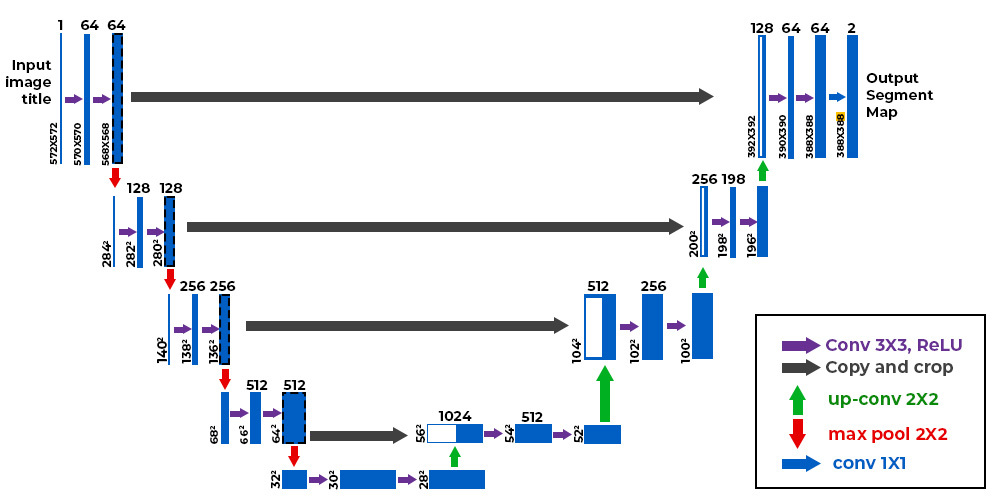


### **Explication de la sortie :**
- La dernière couche `Conv2D(8, (1,1), activation="softmax")` génère un tenseur **(256, 512, 8)**.
- Chaque pixel contient un vecteur de **8 probabilités** (une par classe).
- Pour obtenir l’image segmentée finale, on prend `argmax` sur l’axe des classes pour assigner chaque pixel à la classe la plus probable.


### **Résumé :**
✅ **Entrée** : Image `(256,512,3)`  
✅ **Sortie** : Carte de segmentation `(256,512,8)`  
✅ **Activation finale** : `softmax` pour classification pixel par pixel  
✅ **Post-traitement** : `argmax` pour obtenir la classe de chaque pixel  

## **Format des labels de sortie pour la segmentation**

---

Le format des labels dépend de la **fonction de perte** utilisée. Comme ta couche de sortie utilise une activation **softmax** et génère une sortie `(num_batches, 256, 512, 8)`, voici les deux options possibles :  


### **1️⃣ Labels sous forme d’index : `(num_batches, 256, 512)`**  
👉 **Format :** Chaque pixel est représenté par un entier correspondant à l'index de sa classe (0 à 7).  
👉 **Fonction de perte :** `SparseCategoricalCrossentropy(from_logits=False)`  

**Exemple d'un batch de labels :**  
```python
y_true.shape  # (num_batches, 256, 512), dtype=int
y_true[0, 100, 200]  # Exemple : 3 (classe 3 assignée au pixel (100,200))
```

✅ **Avantages** :
- Plus léger en mémoire.  
- Pas besoin de conversion avant l’entraînement.  

🚀 **Comment charger les labels ?**  
```python
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
model.compile(optimizer="adam", loss=loss_fn, metrics=["accuracy"])
```


### **2️⃣ Labels en one-hot : `(num_batches, 256, 512, 8)`**  
👉 **Format :** Chaque pixel est représenté par un vecteur de probabilité où une seule position est à 1 (one-hot encoding).  
👉 **Fonction de perte :** `CategoricalCrossentropy(from_logits=False)`  

**Exemple d'un pixel encodé en one-hot (classe 3)** :  
```python
[0, 0, 0, 1, 0, 0, 0, 0]  # Classe 3 activée
```

✅ **Avantages** :
- Permet de travailler avec des **poids de classes** si les classes sont déséquilibrées.  
- Peut être plus stable pour certaines architectures.  

🚀 **Comment charger les labels ?**  
```python
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
model.compile(optimizer="adam", loss=loss_fn, metrics=["accuracy"])
```
💡 Si tes labels sont sous forme `(num_batches, 256, 512)`, il faut les **convertir en one-hot** avant l’entraînement :  
```python
y_true_onehot = tf.one_hot(y_true, depth=8)  # Convertit (batch, 256, 512) → (batch, 256, 512, 8)
```



### **📌 Quelle approche choisir ?**  
✅ **Si tes labels sont stockés comme une image avec une seule valeur par pixel** → **`SparseCategoricalCrossentropy`** (option 1, plus simple).  
✅ **Si tu veux manipuler les probabilités ou ajuster les poids des classes** → **`CategoricalCrossentropy`** (option 2, one-hot).  

🚀 **Recommandation :** Utilise la première approche `(num_batches, 256, 512)` car elle est plus efficace en mémoire et plus simple à gérer.  


## Les métriques pour la segmentation d'images
---


Voici un tableau récapitulatif des applications des métriques d'évaluation en segmentation d'images :  

| **Applications**         | **Metrics Used**                | **Explanation**  |
|--------------------------|--------------------------------|-----------------|
| **Medical Imaging**      | Dice Coefficient, Hausdorff Distance | Assure une segmentation précise pour la détection de tumeurs, la délimitation des organes et l'identification d'anomalies, essentielle pour le diagnostic et le traitement. |
| **Autonomous Driving**   | IoU, Pixel Accuracy           | Évalue la capacité du modèle à identifier et localiser des objets (piétons, véhicules, panneaux) pour garantir une navigation sécurisée des véhicules autonomes. |
| **Satellite and Aerial Imaging** | IoU, Boundary F1 Score | Analyse la classification du couvert terrestre, la planification urbaine et la surveillance environnementale, en évaluant la précision des régions segmentées et des contours. |
| **Agriculture**          | Dice Coefficient, Precision   | Mesure la segmentation des zones de culture saines et malades, facilitant la gestion des cultures et l’optimisation des rendements. |
| **Augmented Reality (AR)** | IoU, Pixel Accuracy         | Garantit un alignement précis des objets virtuels sur les surfaces du monde réel pour améliorer l’expérience utilisateur. |

Ce tableau synthétise les principales métriques utilisées selon les applications et leur importance.

## Formulas


Voici un tableau récapitulatif des formules des principales métriques d'évaluation en segmentation d'images :  

| **Métrique**           | **Formule**  |
|------------------------|-------------|
| **Dice Coefficient**   | \( \frac{2TP}{2TP + FP + FN} \) |
| **IoU (Intersection over Union)** | \( \frac{TP}{TP + FP + FN} \) |
| **Pixel Accuracy**     | \( \frac{TP + TN}{TP + TN + FP + FN} \) |
| **Precision**         | \( \frac{TP}{TP + FP} \) |
| **Recall (Sensitivity)** | \( \frac{TP}{TP + FN} \) |
| **F1 Score**          | \( \frac{2 \times Precision \times Recall}{Precision + Recall} \) |
| **Boundary F1 Score** | Basé sur la F1 Score mais appliqué aux contours segmentés (requiert un calcul spatial des frontières) |
| **Hausdorff Distance** | \( \max \{ \sup_{a \in A} \inf_{b \in B} d(a,b), \sup_{b \in B} \inf_{a \in A} d(a,b) \} \) (distance maximale entre les frontières de la segmentation et de la vérité terrain) |

Ces formules utilisent les termes :
- **TP (True Positives)** : pixels correctement classés comme appartenant à la classe cible.
- **TN (True Negatives)** : pixels correctement classés comme n'appartenant pas à la classe cible.
- **FP (False Positives)** : pixels incorrectement classés comme appartenant à la classe cible.
- **FN (False Negatives)** : pixels incorrectement classés comme n'appartenant pas à la classe cible.

## Critiques des métriques
Pour évaluer la qualité de la segmentation d'images, on utilise des métriques spécifiques qui comparent les prédictions du modèle aux vrais labels en mesurant la qualité de l'overlapping entre le y_pred et y_true. Voici les principales métriques utilisées pour évaluer la segmentation d'images :
- Pixel accuracy pas recommande lorsquil a une  classe dominante comme le background. prends en compte tp et tn
    - (tn+tp)/(tn+fp+fn+fp)


- precision, recall & dice (f1 Sørensen–Dice index) ok (tp dans le numérateur)
    - p (tp)/(tp+fp) : Precision measures the proportion of true positive pixels among all pixels classified as positive by the model
    - r (tp)/(tp+fn) : Recall, on the other hand, measures the proportion of true positive pixels that were correctly identified out of all actual positive pixels
    - d (tp+tp)/(tp+tp+fn+fp) : Dice is the harmonic mean of precision and recall. It is a common metric for segmentation tasks because it is more sensitive to small objects than accuracy.
    - High precision indicates that the model has a low false positive rate, while high recall indicates a low false negative rate.

- IoU, Jaccard Index : best > tp (intersect) dans le numerateur et union dans le diviseur (diviseur tout sauf tn)
    - (tp)/(tp+fn+fp)
    - dice harmonic mean
    - iou > penalize more fp and add a SMOOTH factor to avoid division by 0 and compute IoU for each class absent in the image

- Soft (on probabilities without argmax) / hard (with argmax as ohe)


## Focus on Jackard Index & Dice Coefficient

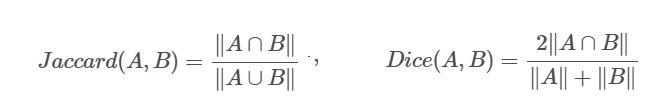

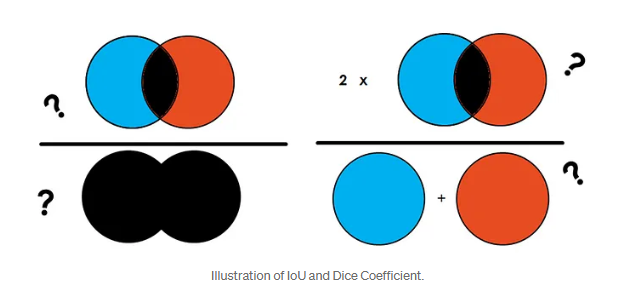


- A gauche, Interesection / Union : IoU = TP / (TP + FP + FN)
- A droite, Dice : Dice (Harmonic mean between recall and precision) = 2 * TP / (2 * TP + FP + FN)

## JACCARD CALCULATION

Let’s calculate the ship IoU first. We assume the total area of the image is 100 (100 pixels). First, let’s think about the ships’ overlap. We can pretend that we move the predicted segmentation (left) directly above the ground truth (right), and see if there are any ship pixels that overlap. Since there are no pixels that are classified as ships by the model, there are 0 overlapping ship pixels.

Union consists of all of the pixels classified as ships from both images, minus the overlap/intersection. In this case, there are 5 pixels (this is an arbitrary number choice) that are classified as ships total. Subtract the overlap/intersection which is 0 to get 5 as the area of union. After doing the calculations, we learn that the IoU is merely 47.5%! See the calculation below.

Here is the detailed calculation:

Ships: Area of Overlap = 0, Area of Union = (5+0)-0 =5

Area of Overlap/Area of Union = 0%

Now for the black background, we do the same thing.

Background: Area of Overlap = 95, Area of Union = (95+100)–95 = 100

Area of Overlap/Area of Union =95%

Mean IoU = (Ships + Background)/2 = (0%+95%)/2 = 47.5%

## DICE CALCULATION

Total Number of Pixels for both images combined = 200

Ships: Area of Overlap = 0

(2 * Area of Overlap)/(total pixels combined) = 0/200 = 0

Background: Area of Overlap = 95

(2 * Area of Overlap)/(total pixels combined) = 95*2/200 = 0.95

Dice = (Ships + Background)/2 = (0%+95%)/2 = 47.5%

## Others metrics

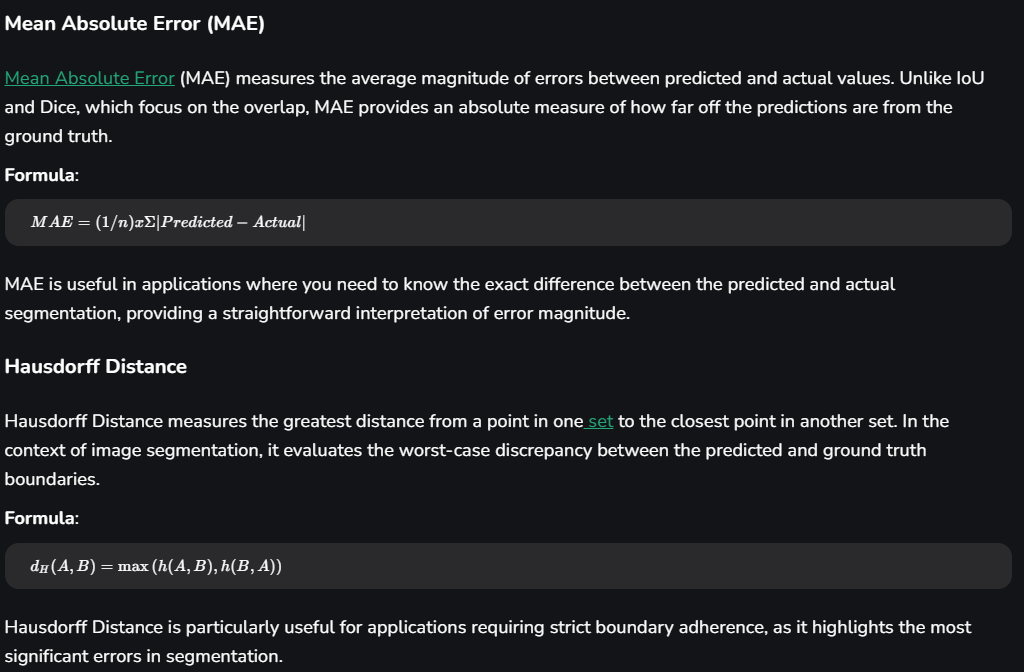

## **ConvNet Architectures**
We have seen that Convolutional Networks are commonly made up of only three layer types: CONV, POOL (we assume Max pool unless stated otherwise) and FC (short for fully-connected). We will also explicitly write the RELU activation function as a layer, which applies elementwise non-linearity. In this section we discuss how these are commonly stacked together to form entire ConvNets.

- Converting FC layers to CONV layers
    - It is worth noting that the only difference between FC and CONV layers is that the neurons in the CONV layer are connected only to a local region in the input, and that many of the neurons in a CONV volume share parameters. However, the neurons in both layers still compute dot products, so their functional form is identical. Therefore, it turns out that it’s possible to convert between FC and CONV layers:


### 📌 **1. Composants d'un CNN**
Un CNN est constitué de plusieurs types de couches :

#### **🔹 Couches Convolutives (Conv Layer)**
- Appliquent des filtres (kernels) pour extraire des **caractéristiques locales**.
- Génèrent des **cartes de caractéristiques (feature maps)**.
- Hyperparamètres : **taille du kernel, stride, padding**.

#### **🔹 Couches d'Activation**
- Introduisent la **non-linéarité**.
- Fonction la plus courante : **ReLU** (Rectified Linear Unit).

#### **🔹 Couches de Pooling (Sous-échantillonnage)**
- Réduisent la **dimensionnalité** et la **sensibilité au bruit**.
- Types :
  - **Max Pooling** : prend la valeur maximale d’une région.
  - **Average Pooling** : prend la moyenne.

#### **🔹 Couches Fully Connected (Dense)**
- Transforme les cartes de caractéristiques en un **vecteur** pour la classification.
- Dernière couche : souvent **Softmax** pour la classification multi-classes.

---

### 🔥 **2. Architectures Populaires de CNN**
Voici quelques architectures CNN célèbres :

#### **1️⃣ LeNet-5 (1998)**
- Premier CNN utilisé pour la reconnaissance de chiffres manuscrits.
- **Structure** :
  - Conv → Pool → Conv → Pool → Dense → Output
- Très simple mais efficace pour de petites images (comme MNIST).

#### **2️⃣ AlexNet (2012)**
- A révolutionné la vision par ordinateur en gagnant ImageNet.
- **Structure** :
  - 5 Convolution + Pooling → 3 Fully Connected
- Introduit **ReLU**, **Dropout** et **GPU training**.

#### **3️⃣ VGG (2014)**
- Approche modulaire avec des **kernels 3x3** pour toutes les convolutions.
- **Variantes : VGG-16, VGG-19**.
- Très profond mais lourd en calcul.

#### **4️⃣ GoogLeNet (Inception) (2014)**
- Introduit les **Inception Blocks** : différentes tailles de filtres en parallèle.
- **Moins de paramètres** qu’AlexNet ou VGG grâce à l’utilisation de convolutions 1x1.

#### **5️⃣ ResNet (2015)**
- Introduit les **skip connections (résiduals)**.
- Résout le problème du **gradient vanishing** dans les réseaux profonds.
- Variantes : **ResNet-18, ResNet-34, ResNet-50, ResNet-101**.

#### **6️⃣ EfficientNet (2019)**
- Basé sur une optimisation du **scaling** (taille des filtres, profondeur, résolution).
- Très performant avec moins de calculs que ResNet.

---

### 🚀 **3. Conception d’un CNN en TensorFlow/Keras**
Un exemple de CNN simple avec **Keras** :

```python
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')  # 10 classes pour classification
])

model.summary()
```

---

### 🎯 **4. Choisir une Architecture CNN**
| **Modèle**   | **Avantages** | **Inconvénients** |
|-------------|--------------|----------------|
| **LeNet-5**  | Simple et rapide | Mauvaise généralisation sur images complexes |
| **AlexNet**  | Performant sur grands datasets | Très lourd en calcul |
| **VGG**      | Facile à implémenter | Nombre de paramètres énorme |
| **GoogLeNet** | Moins de paramètres | Complexe à implémenter |
| **ResNet**   | Permet des réseaux très profonds | Plus gourmand en mémoire |
| **EfficientNet** | Performant et léger | Architecture optimisée difficile à ajuster |


## Conversion des couches FC et CONV

---

### 🔹 **1. Passage de l'extraction de caractéristiques à la classification**
- **Les couches convolutives** apprennent des **descripteurs locaux** (bords, textures, motifs).
- **Les couches fully connected** interprètent ces descripteurs pour faire une **prédiction globale**.
- Convertir une couche conv en dense permet de **transformer les cartes de caractéristiques en un vecteur de décision**.


### 🔹 **2. Compatibilité avec un classifieur classique**
- **Les couches convolutives génèrent des matrices 3D** (hauteur, largeur, canaux).
- **Les couches fully connected prennent des vecteurs en entrée**.
- La conversion (via un `Flatten()`) permet d'utiliser un **classifieur dense** comme Softmax ou une MLP.

🔹 **Exemple en TensorFlow/Keras** :
```python
model = keras.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),  # Conversion de la sortie convolutive en vecteur
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')  # Classification sur 10 classes
])
```
- La couche `Flatten()` convertit la sortie des convolutions en **un vecteur 1D** utilisable par les couches `Dense`.

---

### 🔹 **3. Réduction de la dimensionnalité et adaptation aux tâches**
- Dans certains cas, une conversion en fully connected permet de **réduire la taille des paramètres** et d'ajuster l'architecture.
- Exemple : en **transformant les cartes de caractéristiques en un vecteur plus petit**, on peut mieux généraliser et éviter le surajustement.

---

### 🔹 **4. Simulation d’une convolution avec une couche Dense**
- Une **couche convolutionnelle peut être réécrite comme une couche dense** si l'on ignore le partage de poids.
- Exemple : une **convolution 1x1 avec autant de filtres que d'entrées** est **équivalente à une couche dense**.

---

### 🔹 **5. Réduction du besoin en mémoire et calcul**
- **Transformer une convolution en fully connected** peut parfois réduire la mémoire et accélérer l’inférence.
- Exemple : Dans certains modèles mobiles (**MobileNet, SqueezeNet**), une **dernière convolution 1x1 remplace les couches fully connected** pour réduire le nombre de paramètres.

---

### 🎯 **Conclusion**
✅ **Transformer une couche convolutive en fully connected** permet :
- D’adapter les sorties convolutives pour une tâche de classification.
- D’obtenir un vecteur compatible avec des classifieurs denses.
- De modifier l’architecture pour réduire la complexité.

👉 **Alternatives modernes** : Au lieu de `Flatten()`, certains modèles utilisent **Global Average Pooling (GAP)** pour obtenir une sortie plus robuste et compacte :

```python
layers.GlobalAveragePooling2D()
```

## Pooling vs Convolution avec Stride

---

### 🔹 **1. Différences entre Pooling et Convolution avec Stride**
| **Critère** | **Pooling (Max/Average)** | **Convolution avec Stride** |
|------------|--------------------------|----------------------------|
| **Principe** | Sous-échantillonne l’image en prenant un maximum (max pooling) ou une moyenne (average pooling). | Utilise des filtres qui glissent sur l’image avec un pas (`stride > 1`), supprimant ainsi des pixels. |
| **Perte d’information** | Peut perdre des détails importants (surtout avec max pooling). | Garde plus d’informations car la convolution apprend des poids adaptés. |
| **Paramètres appris** | Aucun (opération fixe). | Oui (les poids du filtre sont optimisés pendant l’entraînement). |
| **Consommation mémoire** | Moins coûteux (aucun paramètre à apprendre). | Plus gourmand en calculs (paramètres à optimiser). |
| **Effet sur le gradient** | Peut causer des pertes d’informations abruptes et un gradient moins stable. | Lisse mieux la propagation du gradient grâce aux poids appris. |

---

### 🔥 **2. Pourquoi utiliser une convolution avec stride à la place du pooling ?**
#### ✅ **Avantages de la convolution avec stride :**
1. **Meilleure optimisation** :  
   - Les **poids du filtre** sont appris, contrairement au pooling qui est une opération fixe.
   - Permet au modèle d’optimiser l’extraction de caractéristiques sans perdre trop d’informations.
   
2. **Propagation du gradient améliorée** :  
   - Moins de perte d’information abrupte que le max pooling.
   - Réduit le risque de disparition du gradient dans les réseaux très profonds.

3. **Moins d’opérations distinctes** :  
   - Évite d’avoir une couche supplémentaire pour le pooling → simplifie l’architecture.

4. **Utilisé dans les architectures modernes** :  
   - **ResNet, MobileNet, DenseNet** préfèrent **les convolutions avec stride** au lieu des **poolings classiques**.

---

### ⚠️ **3. Mais faut-il complètement éviter le pooling ?**
Pas forcément ! Il existe des cas où le **pooling reste utile** :

1. **Max pooling pour une meilleure invariance aux translations**  
   - Le max pooling **réduit la sensibilité aux petits déplacements** dans l’image.
   - Utile pour **des tâches de reconnaissance d’objets** où la position exacte n’est pas importante.

2. **Average pooling dans les architectures récentes**  
   - Le **Global Average Pooling (GAP)** est souvent utilisé pour réduire les dimensions tout en gardant une bonne généralisation :
   ```python
   layers.GlobalAveragePooling2D()
   ```
   - Utilisé dans **ResNet, MobileNet** pour éviter des couches fully connected trop grandes.

---

### 🎯 **4. Recommandation selon les cas**
| **Cas d’usage** | **Pooling classique** | **Convolution avec stride** |
|----------------|----------------------|----------------------------|
| **Tâches classiques (classification d’images)** | ✅ Max Pooling souvent efficace. | 🚫 Pas toujours nécessaire. |
| **Modèles modernes (MobileNet, ResNet, EfficientNet)** | 🚫 Souvent remplacé par GAP. | ✅ Strided Convolution préférable. |
| **Besoin d’invariance aux translations** | ✅ Max Pooling utile. | 🚫 Moins efficace. |
| **Optimisation des calculs sur GPU** | 🚫 Pooling moins flexible. | ✅ Strided Convolution plus efficace sur certains hardware. |

---

### 🎯 **Conclusion**
👉 **Remplacer le pooling par une convolution avec stride est souvent bénéfique**, mais pas toujours obligatoire.  
👉 Les architectures modernes tendent à privilégier **les convolutions avec stride ou le Global Average Pooling (GAP)** au lieu du max pooling.  
👉 **Si tu veux un réseau plus optimisé et entraînable, évite le pooling et favorise les convolutions avec stride.** 🚀  

Tu travailles sur quel type de CNN ? 😊

## CONV LAYER & POOL LAYER Input to Output

### CONV LAYER FILTERS (K) AND STRIDE (S) AND PADDING (P) AND SPATIAL EXTENT (F) vs W x H x D (input) 
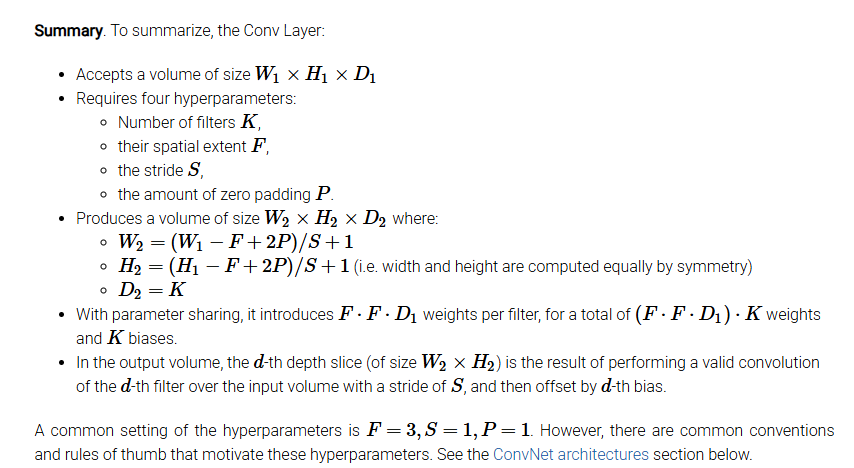

### POOL LAYER FILTERS (K) AND STRIDE (S) AND SPATIAL EXTENT (F) vs W x H x D (input)
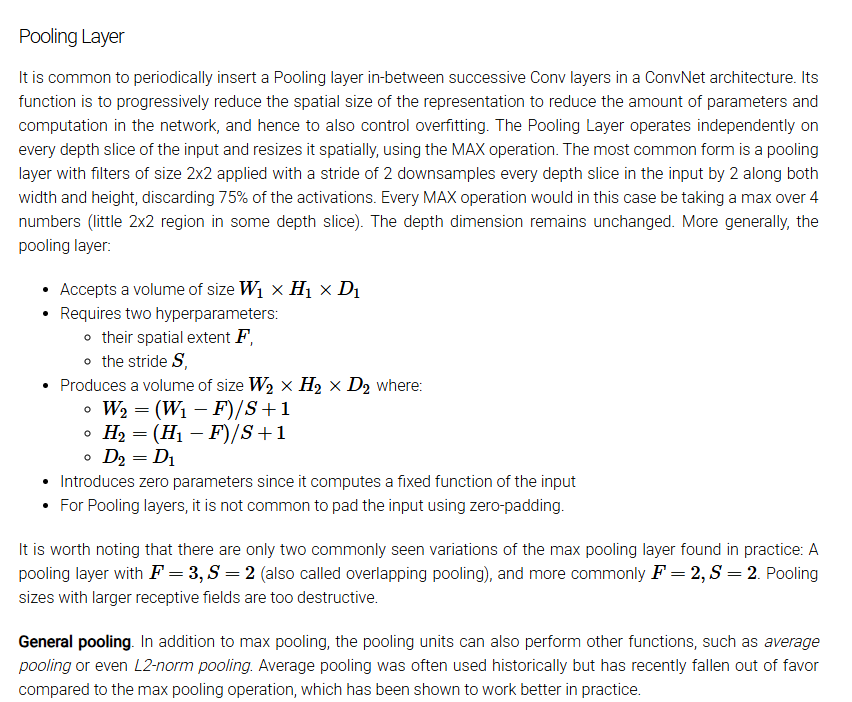

# Code

In [288]:
import pathlib
import os
import math
import pandas as pd
import time
import json
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import logging
import seaborn as sns
import multiprocessing
from utils_and_constants import labels
import typing
import albumentations as A
from sklearn.model_selection import train_test_split

np.random.seed(314)
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
logging.basicConfig(level=logging.ERROR)

# Présentation des données 

**====================  Dossier `Raw`  ====================**


Le jeu de données utilisé pour la conception du modèle de segmentation d'images est composé de deux répertoires:
- Un répertoire `gtFine` contenant les images de masques annotées (20 000 fichiers). Chaque image se distingue par 4 fichiers différents:
    - Un fichier `color` en couleurs (5 000 fichiers png)
    - Un fichier `instanceIds` en niveaux de gris (5 000 fichiers png)
    - Un fichier `labelIds` en niveaux de gris (5 000 fichiers png)
    - Un fichier `polygons` contenant les coordonnées des zones segmentéees (5 000 fichiers json)
- Un répertoire `leftImg8bit` contenant les images brutes en couleurs (5 000 fichiers)


Chacun de ces répertoires est ensuite subdivisé en trois sous répertoires, qui eux mêmes contiennent des sous-répertoires en fonction des villes:
- `train` contenant les données d'entraînement (2975 images)
- `val` contenant les données de validation  (500 images)
- `test` dont les annotations ne sont pas rendues publiques, donc inexploitables dans le cas présent (1525 images)


Pour plus d'informations sur le dataset, merci de lire le README suivant : https://github.com/mcordts/cityscapesScripts/blob/master/README.md

**====================  Dossier `Sorted`  ====================**


La première étape consiste à préparer les dossiers pour le jeu d'entraînement, de validation et de test dans ce nouveau dossier.<br>
Premièrement, on ignore les dossiers de test puisque nous n'avons pas accès aux annotations.<br>


Après ces étapes de préparation, le dossier `Sorted` contiendra les données suivantes:
- Un répertoire `train` contenant uniquement les fichiers d'images et de masques d'entraînement en niveaux de gris `labelIds` et en couleur `color` soit un total de 2975 * 3 = 8925 fichiers
- Un répertoire `test` contenant uniquement les fichiers d'images et de masques de validation du dossier `val` en niveaux de gris `labelIds` et en couleur `color` soit un total de 500 * 3 = 1500 fichiers


Commençons par vérifier que nous avons bien toutes les données après avoir exécutées les commandes bash dans le terminal:

In [2]:
TARGET_SIZE = (256, 512)
print("New Target Shape: ", TARGET_SIZE)
print("Number of CPU cores available: ", NUM_WORKERS := os.cpu_count())


New Target Shape:  (256, 512)
Number of CPU cores available:  16


In [3]:
class Dataloaderv10(tf.keras.utils.PyDataset):
    def __init__(
        self,
        paths: typing.List[pathlib.Path],
        labels: typing.NamedTuple,
        batch_size: int,
        target_size: typing.Tuple[int, int],
        augmentations: False,
        preview: int = None,  # Load only a subset of the dataset for preview.
        normalize: bool = True,
        shuffle: bool = True,
        label_onehot: bool = False,
        threadpool: bool = False,
        **kwargs,
    ):
        """
        Initialize the Dataloaderv9 data generator.
        """
        super().__init__(**kwargs)

        # Logger initialization
        self.logger = self._setup_logger()

        # Set class attributes initialized with constructor arguments
        self.paths = paths
        self.labels = labels
        self.batch_size = batch_size
        self.target_size = target_size
        self.augmentations = augmentations
        self.normalize = normalize
        self.shuffle = shuffle
        self.label_onehot = label_onehot
        self.threadpool = threadpool  # If True, use multiprocessing.Pool

        # Initialize the augmentation pipeline
        if self.augmentations:
            self.compose = A.Compose(
                [
                    A.HorizontalFlip(p=0.9),
                    A.RandomBrightnessContrast(
                        p=0.2, brightness_limit=0.2, contrast_limit=0.2
                    ),
                    A.Blur(p=0.2, blur_limit=3),
                    A.HueSaturationValue(p=0.2, hue_shift_limit=20, sat_shift_limit=30),
                ]
            )

        # Get image and mask file paths using pathlib
        self.image_paths, self.mask_paths = self._load_paths(preview)
        self._validate_paths()

        # Attributes initialized from labels elements
        self.table_id2category = {label.id: label.categoryId for label in self.labels}
        self.num_classes = len(set(self.table_id2category.values()))
        # Disable PIL logging DEBUG
        logging.getLogger("PIL").setLevel(logging.WARNING)

        # Shuffle the dataset before starting
        if self.shuffle:
            self.on_epoch_end()

    # Initialize logger
    def _setup_logger(self):
        logger = logging.getLogger("dataloader")
        logger.setLevel(logging.DEBUG)
        return logger

    # Load image and mask paths and apply preview if requested to slice the dataset
    def _load_paths(self, preview: int):
        # Get image and mask file paths using pathlib
        self.image_paths, self.mask_paths = zip(*self.paths)

        # Apply preview if requested
        if preview is not None:
            image_paths = self.image_paths[:preview]
            mask_paths = self.mask_paths[:preview]

        return image_paths, mask_paths

    # Validate that the number of images and masks are equal before starting
    def _validate_paths(self):
        if len(self.image_paths) != len(self.mask_paths):
            self.logger.error(
                "Number of images (%d) and masks (%d) must be equal.",
                len(self.image_paths),
                len(self.mask_paths),
            )
            raise ValueError("Number of images and masks must be equal.")

    # Return the number of samples in the dataset using dynamic property
    @property
    def num_samples(self):
        return len(self.image_paths)

    # Class method to return the number of batches in the dataset using len()
    def __len__(self) -> int:
        length = math.ceil(self.num_samples / self.batch_size)
        self.logger.debug(f"Number of batches: {length}")
        return length

    # Class method to fetch a batch of images and masks with the given index
    def __getitem__(self, index: int):
        # Calculate start and end indices for the batch
        start_idx = index * self.batch_size
        end_idx = min(start_idx + self.batch_size, self.num_samples)
        if start_idx >= self.num_samples:
            raise IndexError("Index out of range")

        # Prépare les paires (image_path, mask_path) du batch
        batch_paths = list(
            zip(
                self.image_paths[start_idx:end_idx],
                self.mask_paths[start_idx:end_idx],
            )
        )

        # Log the batch fetching
        self.logger.debug(
            f"Fetching batch {index}: start_idx={start_idx}, end_idx={end_idx}"
        )

        # Load images and masks using multiprocessing if threadpool is True
        if self.threadpool:
            self.use_multiprocessing = False
            with multiprocessing.Pool() as pool:
                results = pool.map(self.load_and_augment, batch_paths)
        # Load images and masks using list comprehension if threadpool is False
        else:
            results = [self.load_and_augment(pair) for pair in batch_paths]

        # Return batch images and masks as numpy arrays
        batch_images, batch_masks = zip(*results)
        return np.asarray(batch_images), np.asarray(batch_masks)

    # Shuffle the dataset before starting a new epoch
    def on_epoch_end(self):
        if self.shuffle:
            zip_paths = list(zip(self.image_paths, self.mask_paths))
            np.random.shuffle(zip_paths)
            self.image_paths, self.mask_paths = zip(*zip_paths)
        else:
            pass

    # Normalize the image array if normalize is True
    def _normalize_img(self, img_array):
        return img_array / 255.0

        # Transform mask to categorical one-hot encoding

    def _transform_mask_to_categorical(self, mask):
        return tf.keras.utils.to_categorical(mask, num_classes=self.num_classes)

    # Load image to array and normalize if normalize is True
    def load_img_to_array(self, img_path: pathlib.Path):
        img = tf.keras.utils.load_img(
            str(img_path),
            target_size=self.target_size,
            color_mode="rgb",
            interpolation="bilinear",
        )
        img_array = tf.keras.utils.img_to_array(img, dtype=np.float32)
        if self.normalize:
            img_array = self._normalize_img(img_array)
        return img_array

    # Load mask to array and map mask ids to categories
    def load_mask_to_array(self, mask_path: pathlib.Path):
        mask = tf.keras.utils.load_img(
            str(mask_path),
            target_size=self.target_size,
            color_mode="grayscale",
            interpolation="nearest",
        )
        mask_array = tf.keras.utils.img_to_array(mask, dtype=np.int8)
        # Map mask ids to categories
        mapped = (np.vectorize(self.table_id2category.get)(mask_array)).squeeze()
        if self.label_onehot:
            mapped = self._transform_mask_to_categorical(mapped)
        return mapped

    def load_and_augment(self, paths):
        img, mask = paths
        img = self.load_img_to_array(img)
        mask = self.load_mask_to_array(mask)
        if self.augmentations:
            augmented = self.compose(image=img, mask=mask)
            return augmented["image"], augmented["mask"]
        else:
            return img, mask

    # Return an image and mask pair for visualization with the path
    def get_image_mask_and_paths(self, index: int):
        paths = self.image_paths[index], self.mask_paths[index]
        img, mask = self.load_and_augment(paths)
        return img, mask, *paths

In [4]:
# Path to the root directory
root_dir = pathlib.Path.cwd().parent
# Path to the train directory
train_dir = root_dir / "data" / "Sorted" / "train"
# Path to the test directory
test_dir = root_dir / "data" / "Sorted" / "test"
# Print the number of files after sorting the files
print("Train files: ", len(os.listdir(train_dir)))
print("Test files: ", len(os.listdir(test_dir)))

Train files:  8925
Test files:  1500


In [5]:
image_paths = sorted(list(train_dir.glob("*leftImg8bit.png")))
mask_paths = sorted(list(train_dir.glob("*labelIds.png")))
image_train, image_val, mask_train, mask_val = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=314
)
train_paths = list(zip(image_train, mask_train))
val_paths = list(zip(image_val, mask_val))

In [6]:
image_paths = sorted(list(test_dir.glob("*leftImg8bit.png")))
mask_paths = sorted(list(test_dir.glob("*labelIds.png")))
test_paths = list(zip(image_paths, mask_paths))

In [234]:
%%timeit -r 5 -n 1
datagen = Dataloaderv10(
    train_paths,
    labels,
    batch_size=64,
    target_size=TARGET_SIZE,
    workers=NUM_WORKERS,
    preview=128,
    threadpool=True,
    augmentations=True,
    shuffle=True,
    label_onehot=True,
    use_multiprocessing=False,
    normalize=True,
)
for batch_images, batch_masks in datagen:
    print(batch_images.shape, batch_masks.shape)
    print(batch_images[0].shape, batch_masks[0].shape)

DEBUG:dataloader:Fetching batch 0: start_idx=0, end_idx=64


DEBUG:dataloader:Fetching batch 1: start_idx=64, end_idx=128


(64, 256, 512, 3) (64, 256, 512, 8)
(256, 512, 3) (256, 512, 8)


DEBUG:dataloader:Fetching batch 0: start_idx=0, end_idx=64


(64, 256, 512, 3) (64, 256, 512, 8)
(256, 512, 3) (256, 512, 8)


DEBUG:dataloader:Fetching batch 1: start_idx=64, end_idx=128


(64, 256, 512, 3) (64, 256, 512, 8)
(256, 512, 3) (256, 512, 8)


DEBUG:dataloader:Fetching batch 0: start_idx=0, end_idx=64


(64, 256, 512, 3) (64, 256, 512, 8)
(256, 512, 3) (256, 512, 8)


DEBUG:dataloader:Fetching batch 1: start_idx=64, end_idx=128


(64, 256, 512, 3) (64, 256, 512, 8)
(256, 512, 3) (256, 512, 8)


DEBUG:dataloader:Fetching batch 0: start_idx=0, end_idx=64


(64, 256, 512, 3) (64, 256, 512, 8)
(256, 512, 3) (256, 512, 8)


DEBUG:dataloader:Fetching batch 1: start_idx=64, end_idx=128


(64, 256, 512, 3) (64, 256, 512, 8)
(256, 512, 3) (256, 512, 8)


DEBUG:dataloader:Fetching batch 0: start_idx=0, end_idx=64


(64, 256, 512, 3) (64, 256, 512, 8)
(256, 512, 3) (256, 512, 8)


DEBUG:dataloader:Fetching batch 1: start_idx=64, end_idx=128


(64, 256, 512, 3) (64, 256, 512, 8)
(256, 512, 3) (256, 512, 8)
(64, 256, 512, 3) (64, 256, 512, 8)
(256, 512, 3) (256, 512, 8)
5.93 s ± 624 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


- 1.93 (v9)
- 2.4 (v9_)

# Model

In [7]:
def encoder_block(inputs, num_filters):
    # Convolution with 3x3 filter followed by ReLU activation
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(inputs)
    x = tf.keras.layers.Activation("relu")(x)

    # Convolution with 3x3 filter followed by ReLU activation
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(x)
    x = tf.keras.layers.Activation("relu")(x)

    # Max Pooling with 2x2 filter
    x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2)(x)

    return x


In [8]:
def decoder_block(inputs, skip_features, num_filters):
    # Upsampling with 2x2 filter
    x = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(
        inputs
    )

    # Copy and crop the skip features
    # to match the shape of the upsampled input
    skip_features = ResizeSkipFeatures()([x, skip_features])
    x = tf.keras.layers.Concatenate()([x, skip_features])

    # Convolution with 3x3 filter followed by ReLU activation
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(x)
    x = tf.keras.layers.Activation("relu")(x)

    # Convolution with 3x3 filter followed by ReLU activation
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(x)
    x = tf.keras.layers.Activation("relu")(x)

    return x


In [9]:
class ResizeSkipFeatures(tf.keras.layers.Layer):
    def call(self, inputs):
        x, skip_features = inputs
        return tf.image.resize(skip_features, size=(tf.shape(x)[1], tf.shape(x)[2]))

In [254]:
def unet_model(input_shape=(256, 512, 3), num_classes=8, name="u-net"):
    inputs = tf.keras.layers.Input(input_shape)

    # Contracting Path
    s1 = encoder_block(inputs, 64)
    s2 = encoder_block(s1, 128)
    s3 = encoder_block(s2, 256)
    s4 = encoder_block(s3, 512)

    # Bottleneck
    b1 = tf.keras.layers.Conv2D(1024, 3, padding="same")(s4)
    b1 = tf.keras.layers.Activation("relu")(b1)
    b1 = tf.keras.layers.Conv2D(1024, 3, padding="same")(b1)
    b1 = tf.keras.layers.Activation("relu")(b1)

    # Expansive Path
    s5 = decoder_block(b1, s4, 512)
    s6 = decoder_block(s5, s3, 256)
    s7 = decoder_block(s6, s2, 128)
    s8 = decoder_block(s7, s1, 64)

    # Output
    outputs = tf.keras.layers.Conv2D(
        num_classes, 1, padding="same", activation="softmax"
    )(s8)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name="U-Net")
    return model


In [255]:
model = unet_model()
model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_29      │ (None, 256, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_551 (Conv2D) │ (None, 256, 512,  │      1,792 │ input_layer_29[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_522      │ (None, 256, 512,  │          0 │ conv2d_551[0][0]  │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_552 (Conv2D) │ (None, 256, 512,  │     36,928 │ activation_522[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_523      │ (None, 256, 512,  │          0 │ conv2d_552[0][0]  │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_116   │ (None, 128, 256,  │          0 │ activation_523[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_553 (Conv2D) │ (None, 128, 256,  │     73,856 │ max_pooling2d_11… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_524      │ (None, 128, 256,  │          0 │ conv2d_553[0][0]  │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_554 (Conv2D) │ (None, 128, 256,  │    147,584 │ activation_524[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_525      │ (None, 128, 256,  │          0 │ conv2d_554[0][0]  │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_117   │ (None, 64, 128,   │          0 │ activation_525[0… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_555 (Conv2D) │ (None, 64, 128,   │    295,168 │ max_pooling2d_11… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_526      │ (None, 64, 128,   │          0 │ conv2d_555[0][0]  │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_556 (Conv2D) │ (None, 64, 128,   │    590,080 │ activation_526[0… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_527      │ (None, 64, 128,   │          0 │ conv2d_556[0][0]  │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_118   │ (None, 32, 64,    │          0 │ activation_527[0… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_557 (Conv2D) │ (None, 32, 64,    │  1,180,160 │ max_pooling2d_11

 Total params: 31,032,200 (118.38 MB)

 Trainable params: 31,032,200 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

Exemple de calcul de métrique ou y_true et y_pred sont des tensors de shape (batch_size, height, width, num_classes) , ce qui n'dest pas notre cas (à adapter avec y_true en sparse)

In [230]:
class DiceMetric(tf.keras.metrics.Metric):
    def __init__(self, num_classes, smooth=1e-5, name="dice_metric", **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.smooth = smooth
        self.total_dice = self.add_weight(name="total_dice", initializer="zeros")
        self.count = self.add_weight(name="count", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert the sparse y_true to one-hot encoding
        y_true_onehot = tf.one_hot(
            y_true, depth=self.num_classes
        )  # (batch, h, w, num_classes)

        # Convert the y_pred probabilities with argmax
        y_pred_indices = tf.argmax(y_pred, axis=-1)  # (batch, h, w)
        # Convert the y_pred indices to one-hot encoding
        y_pred_onehot = tf.one_hot(
            y_pred_indices, depth=self.num_classes
        )  # (batch, h, w, num_classes)

        # Flatten the one-hot tensors on all axes except batch
        y_true_flat = tf.reshape(
            y_true_onehot, [tf.shape(y_true_onehot)[0], -1, self.num_classes]
        )  # (batch, h*w, num_classes)
        y_pred_flat = tf.reshape(
            y_pred_onehot, [tf.shape(y_pred_onehot)[0], -1, self.num_classes]
        )  # (batch, h*w, num_classes)

        # Compute intersection and union for each class
        intersection = tf.reduce_sum(
            y_true_flat * y_pred_flat, axis=1
        )  # (batch, num_classes)
        union = tf.reduce_sum(y_true_flat, axis=1) + tf.reduce_sum(
            y_pred_flat, axis=1
        )  # (batch, num_classes)

        # Compute DICE score for each class with the smoothening factor
        dice = (2.0 * intersection + self.smooth) / (union + self.smooth)

        # Compute the DICE mean score for each image
        dice_per_image = tf.reduce_mean(dice, axis=-1)  # (batch,)

        # Update the total dice and count with the mean dice score per image
        self.total_dice.assign_add(tf.reduce_sum(dice_per_image))
        self.count.assign_add(tf.cast(tf.size(dice_per_image), tf.float32))

    def result(self):
        # Compute the mean dice score over all images
        return self.total_dice / self.count

    def reset_states(self):
        # Reset the total dice and count at the end of each epoch
        self.total_dice.assign(0.0)
        self.count.assign(0.0)

In [231]:
mean_metrics = [
    tf.keras.metrics.MeanIoU(
        num_classes=8,
        name="MeanIoU",
        dtype=None,
        ignore_class=None,  # Add Void if necessary
        sparse_y_true=True,  # As we are using sparse categorical crossentropy, the ground truth is sparse
        sparse_y_pred=False,  # As we are using softmax activation, the output is not sparse
        axis=-1,
    ),
    DiceMetric(num_classes=8, name="Dice"),
    tf.keras.metrics.SparseCategoricalAccuracy(name="Pixel_Accuracy"),
]

In [232]:
per_class_metrics = [
    tf.keras.metrics.IoU(
        num_classes=8,
        target_class_ids=[i],  # Compute the IoU for the background class (class 0)
        name=f"IoU_class_{i}",
        sparse_y_true=True,
        sparse_y_pred=False,
        axis=-1,
    )
    for i in range(8)
]

In [169]:
scores = []
for i in range(3):
    m = tf.keras.metrics.IoU(
        num_classes=3, target_class_ids=[i], sparse_y_pred=True, sparse_y_true=True
    )
    m.update_state(
        [1, 2, 2, 1, 2, 2],  # y_true
        [1, 1, 2, 2, 2, 1],  # y_pred
        # sample_weight=None or can be [1, 1, 1, 1, 1, 1]
    )
    print(f"IoU class {i} = {m.result().numpy()}")
    scores.append(m.result().numpy())
print(
    f"Mean IoU is biased here because we took into account IoU Class 0 = {np.mean(scores)}"
)

IoU class 0 = 0.0
IoU class 1 = 0.2499999701976776
IoU class 2 = 0.3999999463558197
Mean IoU is biased here because we took into account IoU Class 0 = 0.21666663885116577


In [170]:
m = tf.keras.metrics.MeanIoU(num_classes=3, sparse_y_pred=True, sparse_y_true=True)
m.update_state(
    [1, 2, 2, 1, 2, 2],  # y_true
    [1, 1, 2, 2, 2, 1],  # y_pred
)
print(f"Mean IoU is not biased here = {m.result().numpy()}")

Mean IoU is not biased here = 0.32499998807907104


Le résultat de MeanIoU ne tient pas de la classe "Absente" pour renvoyer la moyenne.

In [350]:
image_paths = sorted(list(train_dir.glob("*leftImg8bit.png")))
mask_paths = sorted(list(train_dir.glob("*labelIds.png")))
image_train, image_val, mask_train, mask_val = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=314
)
train_paths = list(zip(image_train, mask_train))
val_paths = list(zip(image_val, mask_val))

In [351]:
train_datagen = Dataloaderv10(
    train_paths,
    labels,
    batch_size=4,
    target_size=TARGET_SIZE,
    augmentations=False,
    workers=NUM_WORKERS,
    preview=32,
    shuffle=True,
)
val_datagen = Dataloaderv10(
    val_paths,
    labels,
    batch_size=4,
    target_size=TARGET_SIZE,
    augmentations=False,
    workers=NUM_WORKERS,
    preview=16,
    shuffle=False,
)
test_datagen = Dataloaderv10(
    test_paths,
    labels,
    batch_size=4,
    target_size=TARGET_SIZE,
    augmentations=False,
    workers=NUM_WORKERS,
    preview=32,
    shuffle=True,
)

In [352]:
folders = [int(f) for f in os.listdir("../artifacts")]
new_folder = max(folders) + 1 if folders else 0

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=f"../artifacts/{new_folder}/{model.name}_best_model.h5",  # chemin vers le fichier de sauvegarde
    monitor="val_loss",  # surveille la loss
    mode="min",  # on veut minimiser la loss
    save_best_only=True,  # sauvegarde uniquement le meilleur modèle
    verbose=1,
)

callbacks_list = [
                              tf.keras.callbacks.ReduceLROnPlateau(monitor='val_f1_score', factor=0.9, 
                                    patience=learning_rate_epochs, 
                                    verbose=0, mode='max', min_lr=0.0000001),
                  tf.keras.callbacks.ModelCheckpoint(filepath=fn, save_weights_only=True,
                                  monitor='val_f1_score',mode='max', save_best_only=True)]

In [353]:
model = unet_model(input_shape=(256, 512, 3), num_classes=train_datagen.num_classes)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False,  # Set to False if y_pred is a probability distribution (e.g. softmax activation) with shape (batches, H, W, num_classes)*
    name="sparse_categorical_crossentropy",
)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=mean_metrics + per_class_metrics,
    # weighted_metrics=None,
    # steps_per_execution=1,
    # loss_weights=None,
)

In [354]:
float(optimizer.learning_rate.value.numpy())

9.999999747378752e-05

In [355]:
history = model.fit(
    train_datagen,
    validation_data=val_datagen,
    epochs=3,
    callbacks=[checkpoint_callback],
)

DEBUG:dataloader:Number of batches: 8
DEBUG:dataloader:Number of batches: 8
DEBUG:dataloader:Number of batches: 8
DEBUG:dataloader:Fetching batch 0: start_idx=0, end_idx=4
DEBUG:dataloader:Fetching batch 1: start_idx=4, end_idx=8
DEBUG:dataloader:Number of batches: 8


Epoch 1/3


DEBUG:dataloader:Number of batches: 8
DEBUG:dataloader:Number of batches: 8
DEBUG:dataloader:Fetching batch 7: start_idx=28, end_idx=32
DEBUG:dataloader:Fetching batch 2: start_idx=8, end_idx=12
DEBUG:dataloader:Fetching batch 4: start_idx=16, end_idx=20
DEBUG:dataloader:Fetching batch 1: start_idx=4, end_idx=8
DEBUG:dataloader:Fetching batch 5: start_idx=20, end_idx=24
DEBUG:dataloader:Fetching batch 3: start_idx=12, end_idx=16
DEBUG:dataloader:Fetching batch 6: start_idx=24, end_idx=28
DEBUG:dataloader:Fetching batch 0: start_idx=0, end_idx=4
DEBUG:dataloader:Number of batches: 8
DEBUG:dataloader:Number of batches: 8


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - Dice: 0.0809 - IoU_class_0: 0.0000e+00 - IoU_class_1: 0.3159 - IoU_class_2: 0.0000e+00 - IoU_class_3: 0.0000e+00 - IoU_class_4: 0.0000e+00 - IoU_class_5: 0.0317 - IoU_class_6: 0.0000e+00 - IoU_class_7: 0.0000e+00 - MeanIoU: 0.0435 - Pixel_Accuracy: 0.2486 - loss: 2.0641

DEBUG:dataloader:Number of batches: 4
DEBUG:dataloader:Number of batches: 4
DEBUG:dataloader:Number of batches: 4
DEBUG:dataloader:Fetching batch 0: start_idx=0, end_idx=4
DEBUG:dataloader:Fetching batch 1: start_idx=4, end_idx=8
DEBUG:dataloader:Number of batches: 4
DEBUG:dataloader:Number of batches: 4
DEBUG:dataloader:Number of batches: 4
DEBUG:dataloader:Fetching batch 0: start_idx=0, end_idx=4
DEBUG:dataloader:Fetching batch 1: start_idx=4, end_idx=8
DEBUG:dataloader:Fetching batch 2: start_idx=8, end_idx=12
DEBUG:dataloader:Fetching batch 3: start_idx=12, end_idx=16
DEBUG:dataloader:Number of batches: 4
DEBUG:dataloader:Number of batches: 4



Epoch 1: val_loss improved from inf to 2.02299, saving model to ../artifacts/0/U-Net_best_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 57s 6s/step - Dice: 0.0809 - IoU_class_0: 0.0000e+00 - IoU_class_1: 0.3158 - IoU_class_2: 0.0000e+00 - IoU_class_3: 0.0000e+00 - IoU_class_4: 0.0000e+00 - IoU_class_5: 0.0320 - IoU_class_6: 0.0000e+00 - IoU_class_7: 0.0000e+00 - MeanIoU: 0.0435 - Pixel_Accuracy: 0.2484 - loss: 2.0630 - val_Dice: 0.0960 - val_IoU_class_0: 4.6329e-06 - val_IoU_class_1: 0.4105 - val_IoU_class_2: 0.0000e+00 - val_IoU_class_3: 0.0000e+00 - val_IoU_class_4: 0.0000e+00 - val_IoU_class_5: 4.7575e-05 - val_IoU_class_6: 0.0000e+00 - val_IoU_class_7: 0.0000e+00 - val_MeanIoU: 0.0513 - val_Pixel_Accuracy: 0.4065 - val_loss: 2.0230
Epoch 2/3


DEBUG:dataloader:Number of batches: 8
DEBUG:dataloader:Number of batches: 8
DEBUG:dataloader:Fetching batch 4: start_idx=16, end_idx=20
DEBUG:dataloader:Fetching batch 2: start_idx=8, end_idx=12
DEBUG:dataloader:Fetching batch 0: start_idx=0, end_idx=4
DEBUG:dataloader:Fetching batch 6: start_idx=24, end_idx=28
DEBUG:dataloader:Fetching batch 7: start_idx=28, end_idx=32
DEBUG:dataloader:Fetching batch 1: start_idx=4, end_idx=8
DEBUG:dataloader:Fetching batch 3: start_idx=12, end_idx=16
DEBUG:dataloader:Fetching batch 5: start_idx=20, end_idx=24
DEBUG:dataloader:Number of batches: 8
DEBUG:dataloader:Number of batches: 8


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - Dice: 0.1023 - IoU_class_0: 0.0000e+00 - IoU_class_1: 0.3897 - IoU_class_2: 0.0000e+00 - IoU_class_3: 0.0000e+00 - IoU_class_4: 0.0000e+00 - IoU_class_5: 4.3865e-05 - IoU_class_6: 0.0000e+00 - IoU_class_7: 0.0000e+00 - MeanIoU: 0.0487 - Pixel_Accuracy: 0.3883 - loss: 2.0112

DEBUG:dataloader:Number of batches: 4
DEBUG:dataloader:Number of batches: 4
DEBUG:dataloader:Number of batches: 4
DEBUG:dataloader:Fetching batch 0: start_idx=0, end_idx=4
DEBUG:dataloader:Fetching batch 1: start_idx=4, end_idx=8
DEBUG:dataloader:Fetching batch 2: start_idx=8, end_idx=12
DEBUG:dataloader:Fetching batch 3: start_idx=12, end_idx=16
DEBUG:dataloader:Number of batches: 4
DEBUG:dataloader:Number of batches: 4



Epoch 2: val_loss improved from 2.02299 to 1.92302, saving model to ../artifacts/0/U-Net_best_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 50s 6s/step - Dice: 0.1026 - IoU_class_0: 0.0000e+00 - IoU_class_1: 0.3871 - IoU_class_2: 0.0000e+00 - IoU_class_3: 0.0000e+00 - IoU_class_4: 0.0000e+00 - IoU_class_5: 4.1085e-05 - IoU_class_6: 0.0000e+00 - IoU_class_7: 0.0000e+00 - MeanIoU: 0.0484 - Pixel_Accuracy: 0.3858 - loss: 2.0098 - val_Dice: 0.0955 - val_IoU_class_0: 0.0000e+00 - val_IoU_class_1: 0.4066 - val_IoU_class_2: 0.0000e+00 - val_IoU_class_3: 0.0000e+00 - val_IoU_class_4: 0.0000e+00 - val_IoU_class_5: 0.0000e+00 - val_IoU_class_6: 0.0000e+00 - val_IoU_class_7: 0.0000e+00 - val_MeanIoU: 0.0508 - val_Pixel_Accuracy: 0.4066 - val_loss: 1.9230
Epoch 3/3


DEBUG:dataloader:Number of batches: 8
DEBUG:dataloader:Number of batches: 8
DEBUG:dataloader:Fetching batch 6: start_idx=24, end_idx=28
DEBUG:dataloader:Fetching batch 3: start_idx=12, end_idx=16
DEBUG:dataloader:Fetching batch 1: start_idx=4, end_idx=8
DEBUG:dataloader:Fetching batch 5: start_idx=20, end_idx=24
DEBUG:dataloader:Fetching batch 7: start_idx=28, end_idx=32
DEBUG:dataloader:Fetching batch 2: start_idx=8, end_idx=12
DEBUG:dataloader:Fetching batch 4: start_idx=16, end_idx=20
DEBUG:dataloader:Fetching batch 0: start_idx=0, end_idx=4
DEBUG:dataloader:Number of batches: 8
DEBUG:dataloader:Number of batches: 8


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - Dice: 0.0982 - IoU_class_0: 0.0000e+00 - IoU_class_1: 0.3641 - IoU_class_2: 0.0000e+00 - IoU_class_3: 0.0000e+00 - IoU_class_4: 0.0000e+00 - IoU_class_5: 0.0000e+00 - IoU_class_6: 0.0000e+00 - IoU_class_7: 0.0000e+00 - MeanIoU: 0.0455 - Pixel_Accuracy: 0.3641 - loss: 1.9131

DEBUG:dataloader:Number of batches: 4
DEBUG:dataloader:Number of batches: 4
DEBUG:dataloader:Number of batches: 4
DEBUG:dataloader:Fetching batch 0: start_idx=0, end_idx=4
DEBUG:dataloader:Fetching batch 1: start_idx=4, end_idx=8
DEBUG:dataloader:Fetching batch 2: start_idx=8, end_idx=12
DEBUG:dataloader:Fetching batch 3: start_idx=12, end_idx=16
DEBUG:dataloader:Number of batches: 4
DEBUG:dataloader:Number of batches: 4



Epoch 3: val_loss improved from 1.92302 to 1.79796, saving model to ../artifacts/0/U-Net_best_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 48s 6s/step - Dice: 0.0999 - IoU_class_0: 0.0000e+00 - IoU_class_1: 0.3644 - IoU_class_2: 0.0000e+00 - IoU_class_3: 0.0000e+00 - IoU_class_4: 0.0000e+00 - IoU_class_5: 0.0000e+00 - IoU_class_6: 0.0000e+00 - IoU_class_7: 0.0000e+00 - MeanIoU: 0.0455 - Pixel_Accuracy: 0.3643 - loss: 1.9087 - val_Dice: 0.0955 - val_IoU_class_0: 0.0000e+00 - val_IoU_class_1: 0.4066 - val_IoU_class_2: 0.0000e+00 - val_IoU_class_3: 0.0000e+00 - val_IoU_class_4: 0.0000e+00 - val_IoU_class_5: 0.0000e+00 - val_IoU_class_6: 0.0000e+00 - val_IoU_class_7: 0.0000e+00 - val_MeanIoU: 0.0508 - val_Pixel_Accuracy: 0.4066 - val_loss: 1.7980


In [356]:
img, mask, img_path, mask_path = val_datagen.get_image_mask_and_paths(7)
start_time = time.time()
preds = model.predict(tf.expand_dims(img, axis=0))
end_time = time.time()
inference_time = end_time - start_time
print(f"Inference time: {end_time - start_time:.2f} seconds")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
Inference time: 0.53 seconds


(array([1.960e+02, 4.230e+02, 5.980e+02, 4.410e+02, 3.540e+02, 3.360e+02,
        4.900e+02, 5.740e+02, 4.530e+02, 3.460e+02, 4.130e+02, 4.500e+02,
        5.110e+02, 8.310e+02, 1.198e+03, 1.655e+03, 2.240e+03, 2.934e+03,
        3.586e+03, 3.902e+03, 4.071e+03, 4.092e+03, 4.117e+03, 4.259e+03,
        4.178e+03, 4.282e+03, 4.683e+03, 4.829e+03, 5.222e+03, 5.451e+03,
        6.114e+03, 6.177e+03, 7.404e+03, 7.322e+03, 7.429e+03, 7.003e+03,
        5.931e+03, 6.033e+03, 6.326e+03, 2.833e+03, 7.510e+02, 2.770e+02,
        1.470e+02, 6.900e+01, 2.800e+01, 3.600e+01, 4.000e+00, 2.300e+01,
        1.300e+01, 3.700e+01]),
 array([0.01393495, 0.01680727, 0.0196796 , 0.02255193, 0.02542426,
        0.02829658, 0.03116891, 0.03404124, 0.03691357, 0.0397859 ,
        0.04265822, 0.04553055, 0.04840288, 0.05127521, 0.05414753,
        0.05701986, 0.05989219, 0.06276452, 0.06563684, 0.06850918,
        0.0713815 , 0.07425383, 0.07712616, 0.07999849, 0.08287082,
        0.08574314, 0.08861547, 0.09

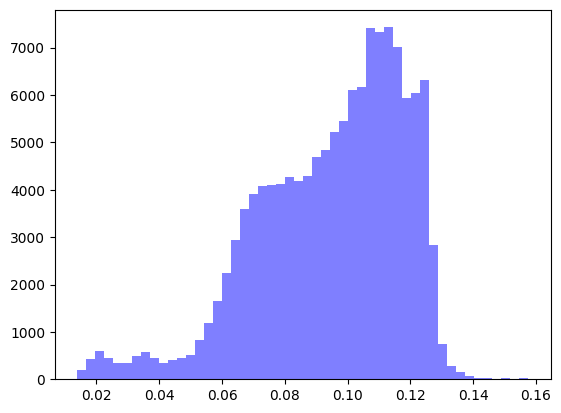

In [362]:
plt.hist(preds.squeeze()[:, :, 0].flatten(), bins=50, color="blue", alpha=0.5)

In [363]:
preds_mask = np.argmax(preds.squeeze(), axis=-1)
preds_mask

array([[1, 1, 1, ..., 1, 1, 2],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

In [364]:
np.unique(preds_mask, return_counts=True)

(array([1, 2]), array([131068,      4]))

In [377]:
params = {
    "epochs": len(history.epoch),
    "model_name": model.name,
    "classes": train_datagen.num_classes,
    "train_samples": train_datagen.num_samples,
    "val_samples": val_datagen.num_samples,
    "test_samples": test_datagen.num_samples,
    "train_batches": len(train_datagen),
    "augmentations": train_datagen.augmentations,
    "normalize": train_datagen.normalize,
    "loss_fn": loss_fn.name,
    "optimizer": optimizer.__class__.__name__,
    "learning_rate": float(optimizer.learning_rate.value.numpy()),
}

DEBUG:dataloader:Number of batches: 8


In [366]:
pd.DataFrame(history.history)

,Dice,IoU_class_0,IoU_class_1,IoU_class_2,IoU_class_3,IoU_class_4,IoU_class_5,IoU_class_6,IoU_class_7,MeanIoU,...,val_IoU_class_1,val_IoU_class_2,val_IoU_class_3,val_IoU_class_4,val_IoU_class_5,val_IoU_class_6,val_IoU_class_7,val_MeanIoU,val_Pixel_Accuracy,val_loss
0,0.081232,0.0,0.314830,0.0,0.0,0.0,0.034263,0.0,0.0,0.043637,...,0.410455,0.0,0.0,0.0,0.000048,0.0,0.0,0.051313,0.406497,2.022990
1,0.105360,0.0,0.366530,0.0,0.0,0.0,0.000019,0.0,0.0,0.045819,...,0.406612,0.0,0.0,0.0,0.000000,0.0,0.0,0.050827,0.406587,1.923017
2,0.113098,0.0,0.366003,0.0,0.0,0.0,0.000000,0.0,0.0,0.045750,...,0.406594,0.0,0.0,0.0,0.000000,0.0,0.0,0.050824,0.406587,1.797958


<Axes: >

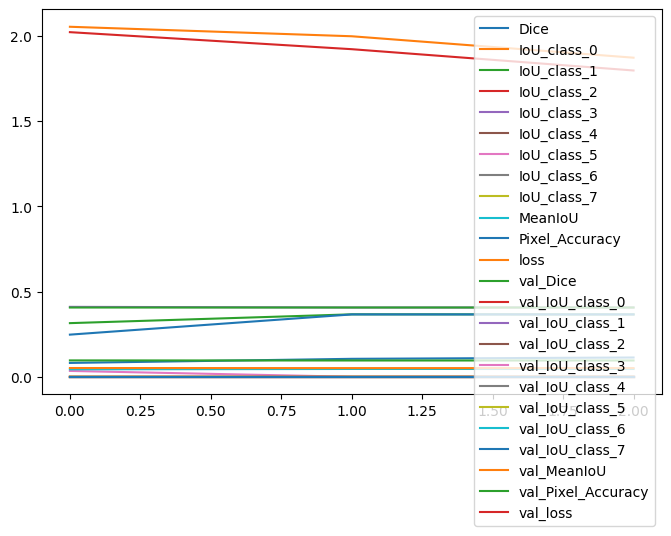

In [367]:
pd.DataFrame(history.history).plot(figsize=(8, 5))

In [368]:
# Take the epoch with the best validation loss
best_val_loss = history.history["val_loss"].index(min(history.history["val_loss"]))

In [378]:
# Dump the metrics and params to a JSON file
with open(f"../artifacts/{new_folder}/{model.name}_history.json", "w") as f:
    json.dump(
        {
            "history": history.history,
            "model_config": model.get_config(),
            "params": params,
            "inference_time": inference_time,
        },
        f,
    )

In [372]:
pd.DataFrame(history.history).iloc[best_val_loss, :].to_frame().T

,Dice,IoU_class_0,IoU_class_1,IoU_class_2,IoU_class_3,IoU_class_4,IoU_class_5,IoU_class_6,IoU_class_7,MeanIoU,...,val_IoU_class_1,val_IoU_class_2,val_IoU_class_3,val_IoU_class_4,val_IoU_class_5,val_IoU_class_6,val_IoU_class_7,val_MeanIoU,val_Pixel_Accuracy,val_loss
2,0.113098,0.0,0.366003,0.0,0.0,0.0,0.0,0.0,0.0,0.04575,...,0.406594,0.0,0.0,0.0,0.0,0.0,0.0,0.050824,0.406587,1.797958


In [386]:
metrics_filepath = "../metrics.csv"
# Take the epoch with the best validation loss
best_epoch = history.history["val_loss"].index(min(history.history["val_loss"]))
# Append the metrics to the metrics.csv file containing best epoch metrics, model name, and inference time and params
metrics_df = pd.DataFrame(history.history).iloc[best_val_loss, :].to_frame().T
metrics_df["best_epoch"] = best_epoch
metrics_df["n_epochs"] = params["epochs"]
metrics_df["model_name"] = model.name
metrics_df["inference_time"] = inference_time
metrics_df.insert(0, "experiment_folder", new_folder)
for key, value in params.items():
    metrics_df[key] = value
if not os.path.exists(metrics_filepath):
    metrics_df.to_csv(metrics_filepath, mode="a", header=True, index=False)
else:
    metrics_df.to_csv(metrics_filepath, mode="a", header=False, index=False)

In [387]:
pd.read_csv(metrics_filepath).drop_duplicates()

,experiment_folder,Dice,IoU_class_0,IoU_class_1,IoU_class_2,IoU_class_3,IoU_class_4,IoU_class_5,IoU_class_6,IoU_class_7,...,classes,train_samples,val_samples,test_samples,train_batches,augmentations,normalize,loss_fn,optimizer,learning_rate
0,0,0.113098,0.0,0.366003,0.0,0.0,0.0,0.0,0.0,0.0,...,8,32,16,32,8,False,True,sparse_categorical_crossentropy,Adam,0.0001


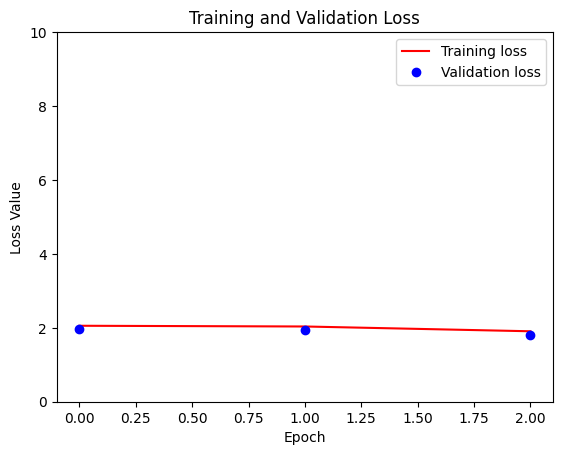

In [272]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.figure()
plt.plot(history.epoch, loss, "r", label="Training loss")
plt.plot(history.epoch, val_loss, "bo", label="Validation loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.ylim([0, 10])
plt.legend()
plt.show()

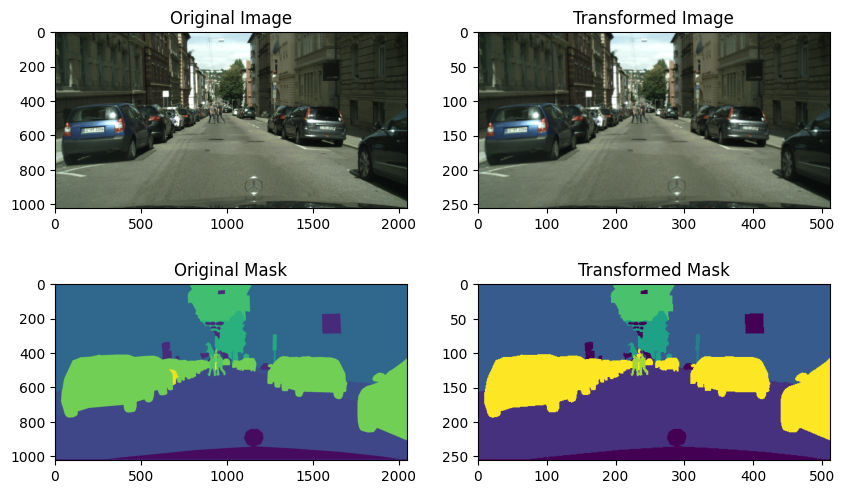

In [273]:
# Display the original and transformed images
fig, ax = plt.subplots(2, 2, figsize=(10, 6))
ax[0, 0].imshow(plt.imread(img_path))
ax[0, 0].set_title("Original Image")
ax[0, 1].imshow(img)
ax[0, 1].set_title("Transformed Image")
ax[1, 0].imshow(plt.imread(mask_path))
ax[1, 0].set_title("Original Mask")
ax[1, 1].imshow(mask)
ax[1, 1].set_title("Transformed Mask")
plt.show()

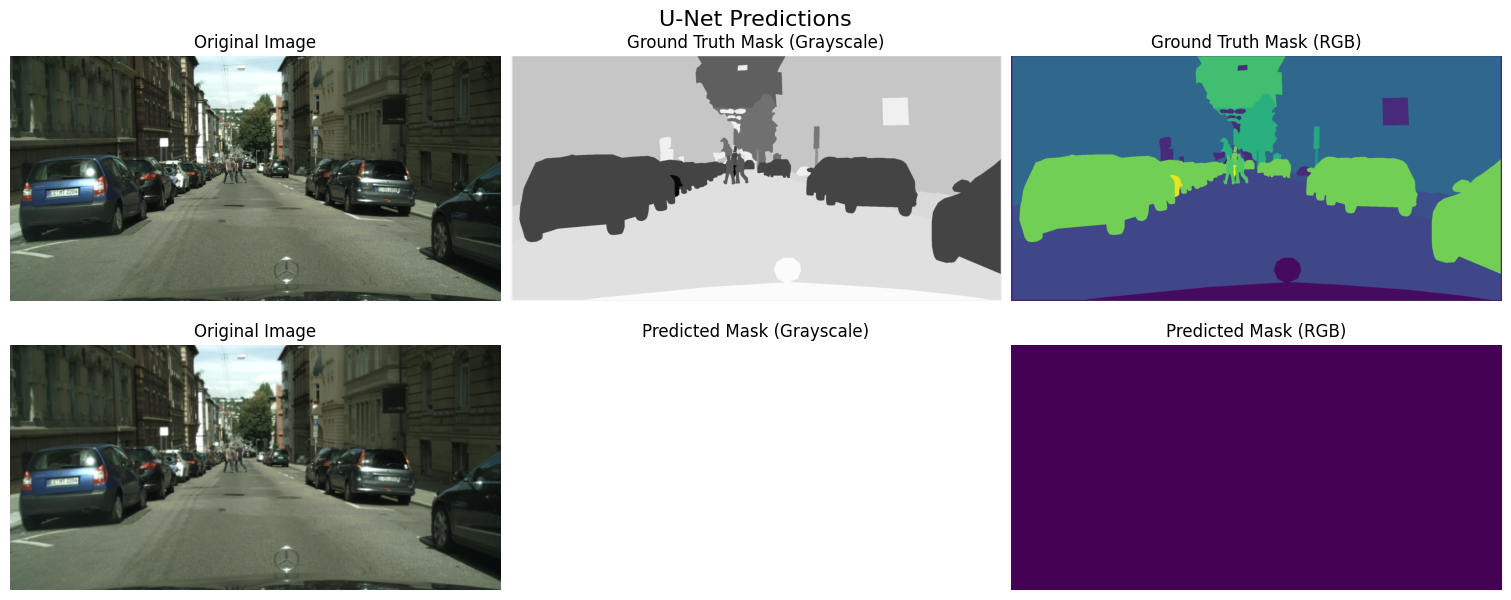

In [274]:
# Create preds_mask
preds_mask = np.argmax(preds.squeeze(), axis=-1)

# Figure initialization
fig = plt.figure(layout="constrained", figsize=(15, 6))
fig.suptitle("U-Net Predictions", fontsize=16)
# Subfigures initialization
subfigs = fig.subfigures(2, 1, wspace=0.07)
axsTop = subfigs[0].subplots(1, 3, sharey=True, sharex=True)
axsBottom = subfigs[1].subplots(1, 3, sharey=True, sharex=True)
for i, ax in enumerate(axsTop):
    if i == 0:
        ax.imshow(plt.imread(img_path))
        ax.set_title("Original Image")
    elif i == 1:
        ax.imshow(plt.imread(mask_path), cmap="Greys")
        ax.set_title("Ground Truth Mask (Grayscale)")
    else:
        ax.imshow(plt.imread(mask_path))
        ax.set_title("Ground Truth Mask (RGB)")
    ax.axis("off")
for i, ax in enumerate(axsBottom):
    if i == 0:
        ax.imshow(img)
        ax.set_title("Original Image")
    elif i == 1:
        ax.imshow(preds_mask, cmap="Greys")
        ax.set_title("Predicted Mask (Grayscale)")
    else:
        ax.imshow(preds_mask)
        ax.set_title("Predicted Mask (RGB)")
    ax.axis("off")
plt.show()

In [20]:
# Pick a color palette for RGB labels with 7 colors (void is ignored)
sns.color_palette("tab10", 7)


[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902)]

# Follow Up Ideas